<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/cris_tabnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
pip install pytorch_tabnet

In [3]:
pip install iterative-stratification

In [4]:
import numpy as np
from joblib import Parallel, delayed
from scipy.interpolate import interp1d
from scipy.special import erf, erfinv
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import FLOAT_DTYPES, check_array, check_is_fitted


class GaussRankScaler(BaseEstimator, TransformerMixin):
    """Transform features by scaling each feature to a normal distribution.
    Parameters
        ----------
        epsilon : float, optional, default 1e-4
            A small amount added to the lower bound or subtracted
            from the upper bound. This value prevents infinite number
            from occurring when applying the inverse error function.
        copy : boolean, optional, default True
            If False, try to avoid a copy and do inplace scaling instead.
            This is not guaranteed to always work inplace; e.g. if the data is
            not a NumPy array, a copy may still be returned.
        n_jobs : int or None, optional, default None
            Number of jobs to run in parallel.
            ``None`` means 1 and ``-1`` means using all processors.
        interp_kind : str or int, optional, default 'linear'
           Specifies the kind of interpolation as a string
            ('linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',
            'previous', 'next', where 'zero', 'slinear', 'quadratic' and 'cubic'
            refer to a spline interpolation of zeroth, first, second or third
            order; 'previous' and 'next' simply return the previous or next value
            of the point) or as an integer specifying the order of the spline
            interpolator to use.
        interp_copy : bool, optional, default False
            If True, the interpolation function makes internal copies of x and y.
            If False, references to `x` and `y` are used.
        Attributes
        ----------
        interp_func_ : list
            The interpolation function for each feature in the training set.
        """

    def __init__(self, epsilon=1e-4, copy=True, n_jobs=None, interp_kind='linear', interp_copy=False):
        self.epsilon = epsilon
        self.copy = copy
        self.interp_kind = interp_kind
        self.interp_copy = interp_copy
        self.fill_value = 'extrapolate'
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        """Fit interpolation function to link rank with original data for future scaling
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to fit interpolation function for later scaling along the features axis.
        y
            Ignored
        """
        X = check_array(X, copy=self.copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        self.interp_func_ = Parallel(n_jobs=self.n_jobs)(delayed(self._fit)(x) for x in X.T)
        return self

    def _fit(self, x):
        x = self.drop_duplicates(x)
        rank = np.argsort(np.argsort(x))
        bound = 1.0 - self.epsilon
        factor = np.max(rank) / 2.0 * bound
        scaled_rank = np.clip(rank / factor - bound, -bound, bound)
        return interp1d(
            x, scaled_rank, kind=self.interp_kind, copy=self.interp_copy, fill_value=self.fill_value)

    def transform(self, X, copy=None):
        """Scale the data with the Gauss Rank algorithm
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _transform(self, i, x):
        return erfinv(self.interp_func_[i](x))

    def inverse_transform(self, X, copy=None):
        """Scale back the data to the original representation
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data used to scale along the features axis.
        copy : bool, optional (default: None)
            Copy the input X or not.
        """
        check_is_fitted(self, 'interp_func_')

        copy = copy if copy is not None else self.copy
        X = check_array(X, copy=copy, estimator=self, dtype=FLOAT_DTYPES, force_all_finite=True)

        X = np.array(Parallel(n_jobs=self.n_jobs)(delayed(self._inverse_transform)(i, x) for i, x in enumerate(X.T))).T
        return X

    def _inverse_transform(self, i, x):
        inv_interp_func = interp1d(self.interp_func_[i].y, self.interp_func_[i].x, kind=self.interp_kind,
                                   copy=self.interp_copy, fill_value=self.fill_value)
        return inv_interp_func(erf(x))

    @staticmethod
    def drop_duplicates(x):
        is_unique = np.zeros_like(x, dtype=bool)
        is_unique[np.unique(x, return_index=True)[1]] = True
        return x[is_unique]

In [5]:
import os
import sys
import copy
import tqdm
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../input/rank-gauss")
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'

### Data Wrangling ###
import numpy as np
import pandas as pd
from scipy import stats

### Data Visualization ###
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

### Machine Learning ###
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

### Deep Learning ###
import torch
from torch import nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Tabnet 
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetRegressor


In [6]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(seed)

In [7]:
# Parameters
data_path = '/content/gdrive/My Drive/moa/'
no_ctl = True
scale = "rankgauss"
variance_threshould = 0.7
decompo = "PCA"
ncompo_genes = 80
ncompo_cells = 10
encoding = "dummy"

In [8]:
train = pd.read_csv(data_path + "train_features.csv")
#train.drop(columns = ["sig_id"], inplace = True)

scored = pd.read_csv(data_path + "train_targets_scored.csv")
#train_targets_scored.drop(columns = ["sig_id"], inplace = True)

#train_targets_nonscored = pd.read_csv(data_path + "train_targets_nonscored.csv")

test = pd.read_csv(data_path + "test_features.csv")
#test.drop(columns = ["sig_id"], inplace = True)


drug = pd.read_csv(data_path+'train_drug.csv')

In [9]:
SEED = 42
FOLDS = 5
targets = scored.columns[1:]
scored = scored.merge(drug, on='sig_id', how='left') 

# LOCATE DRUGS
vc = scored.drug_id.value_counts()
vc1 = vc.loc[vc<=18].index.sort_values()
vc2 = vc.loc[vc>18].index.sort_values()

# STRATIFY DRUGS 18X OR LESS
dct1 = {}; dct2 = {}
skf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True, 
          random_state=SEED)
tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
    dd = {k:fold for k in tmp.index[idxV].values}
    dct1.update(dd)

# STRATIFY DRUGS MORE THAN 18X
skf = MultilabelStratifiedKFold(n_splits=FOLDS, shuffle=True, 
          random_state=SEED)
tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
    dd = {k:fold for k in tmp.sig_id[idxV].values}
    dct2.update(dd)

# ASSIGN FOLDS
scored['fold'] = scored.drug_id.map(dct1)
scored.loc[scored.fold.isna(),'fold'] =\
    scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
scored.fold = scored.fold.astype('int8')

In [10]:
targets = scored

In [11]:
if no_ctl:
    # cp_type == ctl_vehicle
    train = train[train["cp_type"] != "ctl_vehicle"]
    test = test[test["cp_type"] != "ctl_vehicle"]
    targets = targets.iloc[train.index]
    drug = drug.iloc[train.index]
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    targets.reset_index(drop = True, inplace = True)

In [12]:

GENES = [col for col in train.columns if col.startswith("g-")]
CELLS = [col for col in train.columns if col.startswith("c-")]



In [13]:
data_all = pd.concat([train, test], ignore_index = True)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]
mask = (data_all[cols_numeric].var() >= variance_threshould).values
tmp = data_all[cols_numeric].loc[:, mask]
data_all = pd.concat([data_all[["sig_id", "cp_type", "cp_time", "cp_dose"]], tmp], axis = 1)
cols_numeric = [feat for feat in list(data_all.columns) if feat not in ["sig_id", "cp_type", "cp_time", "cp_dose"]]

In [14]:
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())

def scale_norm(col):
    return (col - col.mean()) / col.std()

if scale == "boxcox":
    print(b_, "boxcox")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    trans = []
    for feat in cols_numeric:
        trans_var, lambda_var = stats.boxcox(data_all[feat].dropna() + 1)
        trans.append(scale_minmax(trans_var))
    data_all[cols_numeric] = np.asarray(trans).T
    
elif scale == "norm":
    print(b_, "norm")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_norm, axis = 0)
    
elif scale == "minmax":
    print(b_, "minmax")
    data_all[cols_numeric] = data_all[cols_numeric].apply(scale_minmax, axis = 0)
    
elif scale == "rankgauss":
    scaler = GaussRankScaler()
    data_all[cols_numeric] = scaler.fit_transform(data_all[cols_numeric])
    
else:
    pass

In [15]:
if decompo == "PCA":
    GENES = [col for col in data_all.columns if col.startswith("g-")]
    CELLS = [col for col in data_all.columns if col.startswith("c-")]
    
    pca_genes = PCA(n_components = ncompo_genes,
                    random_state = seed).fit_transform(data_all[GENES])
    pca_cells = PCA(n_components = ncompo_cells,
                    random_state = seed).fit_transform(data_all[CELLS])
    
    pca_genes = pd.DataFrame(pca_genes, columns = [f"pca_g-{i}" for i in range(ncompo_genes)])
    pca_cells = pd.DataFrame(pca_cells, columns = [f"pca_c-{i}" for i in range(ncompo_cells)])
    data_all = pd.concat([data_all, pca_genes, pca_cells], axis = 1)
else:
    pass

In [16]:
if encoding == "lb":
    for feat in ["cp_time", "cp_dose"]:
        data_all[feat] = LabelEncoder().fit_transform(data_all[feat])
elif encoding == "dummy":
    data_all = pd.get_dummies(data_all, columns = ["cp_time", "cp_dose"])

In [17]:
GENES = [col for col in data_all.columns if col.startswith("g-")]
CELLS = [col for col in data_all.columns if col.startswith("c-")]

for stats in tqdm.tqdm(["sum", "mean", "std", "kurt", "skew"]):
    data_all["g_" + stats] = getattr(data_all[GENES], stats)(axis = 1)
    data_all["c_" + stats] = getattr(data_all[CELLS], stats)(axis = 1)    
    data_all["gc_" + stats] = getattr(data_all[GENES + CELLS], stats)(axis = 1)

100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


In [18]:
# train_df and test_df
features_to_drop = ["sig_id", "cp_type"]
data_all.drop(features_to_drop, axis = 1, inplace = True)
try:
    targets.drop("sig_id", axis = 1, inplace = True)
except:
    pass
train_df = data_all[: train.shape[0]]
train_df.reset_index(drop = True, inplace = True)
# The following line it's a bad practice in my opinion, targets on train set
#train_df = pd.concat([train_df, targets], axis = 1)
test_df = data_all[train_df.shape[0]: ]
test_df.reset_index(drop = True, inplace = True)

In [19]:


X_test = test_df.values

In [20]:
MAX_EPOCH = 200
# n_d and n_a are different from the original work, 32 instead of 24
# This is the first change in the code from the original
tabnet_params = dict(
    n_d = 32,
    n_a = 32,
    n_steps = 1,
    gamma = 1.3,
    lambda_sparse = 0,
    optimizer_fn = optim.Adam,
    optimizer_params = dict(lr = 2e-2, weight_decay = 1e-5),
    mask_type = "entmax",
    scheduler_params = dict(
        mode = "min", patience = 5, min_lr = 1e-5, factor = 0.9),
    scheduler_fn = ReduceLROnPlateau,
    seed = seed,
    verbose = 10
)

In [21]:
class LogitsLogLoss(Metric):
    """
    LogLoss with sigmoid applied
    """

    def __init__(self):
        self._name = "logits_ll"
        self._maximize = False

    def __call__(self, y_true, y_pred):
        """
        Compute LogLoss of predictions.

        Parameters
        ----------
        y_true: np.ndarray
            Target matrix or vector
        y_score: np.ndarray
            Score matrix or vector

        Returns
        -------
            float
            LogLoss of predictions vs targets.
        """
        logits = 1 / (1 + np.exp(-y_pred))
        aux = (1 - y_true) * np.log(1 - logits + 1e-15) + y_true * np.log(logits + 1e-15)
        return np.mean(-aux)

In [35]:
scores_auc_all = []
test_cv_preds = []

NB_SPLITS = 10 # 7
mskf = MultilabelStratifiedKFold(n_splits = NB_SPLITS, random_state = 0, shuffle = True)

oof_preds = []
oof_targets = []
scores = []
scores_auc = []
hists = []
for i in range(5):
    train_idx = targets.loc[targets['fold']!=i].index
    val_idx = targets.loc[targets['fold']==i].index

    X_train, y_train = train_df.values[train_idx, :], targets.values[train_idx, :]
    y_train = y_train[:,:-2].astype('uint8')
    X_val, y_val = train_df.values[val_idx, :], targets.values[val_idx, :]
    y_val = y_val[:,:-2].astype('uint8')
    ### Model ###
    model = TabNetRegressor(**tabnet_params)
        
    ### Fit ###
    # Another change to the original code
    # virtual_batch_size of 32 instead of 128
    model.fit(
        X_train = X_train,
        y_train = y_train,
        eval_set = [(X_val, y_val)],
        eval_name = ["val"],
        eval_metric = ["logits_ll"],
        max_epochs = MAX_EPOCH,
        patience = 20,
        batch_size = 1024, 
        virtual_batch_size = 32,
        num_workers = 1,
        drop_last = False,
        # To use binary cross entropy because this is not a regression problem
        loss_fn = F.binary_cross_entropy_with_logits
    )
    hists.append(model.history)
    ### Predict on validation ###
    preds_val = model.predict(X_val)
    # Apply sigmoid to the predictions
    preds = 1 / (1 + np.exp(-preds_val))
    score = np.min(model.history["val_logits_ll"])
    
    ### Save OOF for CV ###
    oof_preds.append(preds_val)
    oof_targets.append(y_val)
    scores.append(score)
    
    ### Predict on test ###
    preds_test = model.predict(X_test)
    test_cv_preds.append(1 / (1 + np.exp(-preds_test)))

oof_preds_all = np.concatenate(oof_preds)
oof_targets_all = np.concatenate(oof_targets)
test_preds_all = np.stack(test_cv_preds)

Device used : cuda
epoch 0  | loss: 0.33216 | val_logits_ll: 0.03255999833345413|  0:00:02s
epoch 10 | loss: 0.01943 | val_logits_ll: 0.019619999453425407|  0:00:23s
epoch 20 | loss: 0.01772 | val_logits_ll: 0.0215000007301569|  0:00:44s
epoch 30 | loss: 0.01718 | val_logits_ll: 0.018309999257326126|  0:01:06s
epoch 40 | loss: 0.01673 | val_logits_ll: 0.019500000402331352|  0:01:27s
epoch 50 | loss: 0.01646 | val_logits_ll: 0.01843000017106533|  0:01:49s
epoch 60 | loss: 0.01633 | val_logits_ll: 0.01868000067770481|  0:02:11s
epoch 70 | loss: 0.01595 | val_logits_ll: 0.017990000545978546|  0:02:32s

Early stopping occured at epoch 72 with best_epoch = 52 and best_val_logits_ll = 0.01775999926030636
Best weights from best epoch are automatically used!
Device used : cuda
epoch 0  | loss: 0.3311  | val_logits_ll: 0.0335099995136261|  0:00:02s
epoch 10 | loss: 0.01923 | val_logits_ll: 0.01899999938905239|  0:00:23s
epoch 20 | loss: 0.01761 | val_logits_ll: 0.01940999925136566|  0:00:44s
ep

In [1]:
(0.017650000751018524+0.01737000048160553+0.017500000074505806+0.01775999926030636+0.01775999926030636)/5

0.017607999965548515

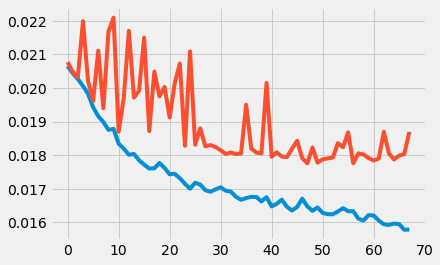

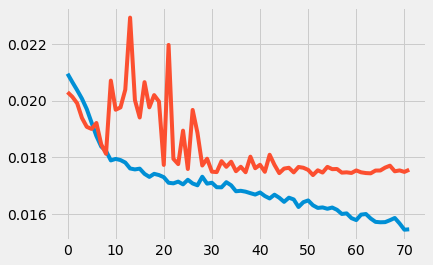

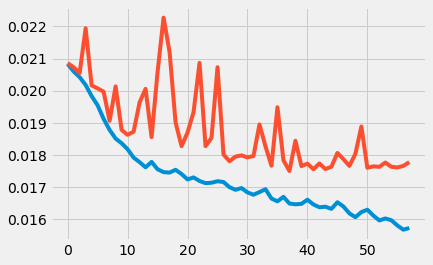

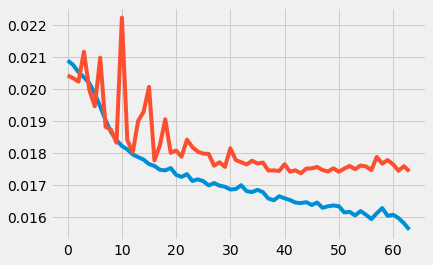

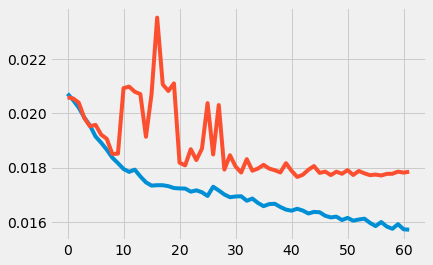

In [37]:
for i in hists:
  plt.plot(i['loss'][5:])
  plt.plot(i['val_logits_ll'][5:])
  plt.show()